In [20]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import os
import json
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches

data_path_train = r'C:\Users\Niloy\Desktop\Adv\train_metadata.json'
with open(data_path_train) as json_file:
    meta_train = json.load(json_file)

#loading json file for test data
data_path_test = r'C:\Users\Niloy\Desktop\Adv\test_metadata.json'
with open(data_path_test) as json_file:
    meta_test = json.load(json_file) 


In [21]:
#Finding keys in train dictionary
meta_train.keys()

dict_keys(['annotations', 'images', 'categories', 'genera', 'institutions', 'distances', 'license'])

In [22]:
#creating seperate dataframes from metadata
annotations_train =  pd.json_normalize(meta_train ['annotations'])
categories_train =  pd.json_normalize(meta_train ['categories'])
images_train =  pd.json_normalize(meta_train ['images'])
genera_train =  pd.json_normalize(meta_train ['genera'])
distance_train =  pd.json_normalize(meta_train ['distances'])
licenses_train =  pd.json_normalize(meta_train ['license'])
institutions_train =  pd.json_normalize(meta_train ['institutions'])

In [23]:
# Complete df
df_merge = pd.merge(images_train[['image_id','file_name']],annotations_train[['genus_id','category_id','image_id']] , on='image_id')
df_merge = pd.merge(df_merge[['genus_id','image_id','file_name','category_id']],categories_train[['category_id','scientificName','family','genus','species']] , on='category_id')
df_merge['file_path']= r'C:/Users/Niloy/Desktop/Adv/images/'+df_merge['file_name']
df_merge['name']=df_merge['genus']+' '+df_merge['species']
df_train = df_merge[['category_id','genus_id','image_id','family','genus','species','name','file_name','file_path']]

df_train.head()

,category_id,genus_id,image_id,family,genus,species,name,file_name,file_path
0,0,1,00000__001,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__001.jpg,C:/Users/Niloy/Desktop/Adv/images/000/00/00000...
1,0,1,00000__002,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__002.jpg,C:/Users/Niloy/Desktop/Adv/images/000/00/00000...
2,0,1,00000__003,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__003.jpg,C:/Users/Niloy/Desktop/Adv/images/000/00/00000...
3,0,1,00000__004,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__004.jpg,C:/Users/Niloy/Desktop/Adv/images/000/00/00000...
4,0,1,00000__005,Pinaceae,Abies,amabilis,Abies amabilis,000/00/00000__005.jpg,C:/Users/Niloy/Desktop/Adv/images/000/00/00000...


(1000, 666, 3)


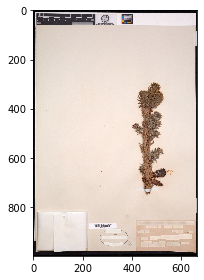

In [24]:
from skimage import util 
from skimage import data, exposure, img_as_float
from skimage import io, exposure, data
from skimage.io import imread, imshow
#test first image to show
%matplotlib inline

img = mpimg.imread(df_train['file_path'][0])
imshow(img)
print(img.shape)


In [25]:
y=[]
def makeimage(i2,img2):
    #image=mpimg.imread(df_train['file_path'][i2])
    if(os.path.exists(df_train['file_path'][i2])):
        img=imread(df_train['file_path'][i2],as_gray=True)
        img=img[100:765,100:595]
        img2.append(np.reshape(img, (665*495)))
        y.append(df_train['category_id'][i2])
   

In [26]:
i2=0
img2=[]
while i2<500 :
    makeimage(i2,img2)
    i2=i2+1

In [27]:
from sklearn import preprocessing
import math
import random
from sklearn.model_selection import train_test_split

img2=np.array(img2)
print(np.array(img2).shape)
X=img2
X= preprocessing.scale(X)

y2=np.array(y)

seed =2 
np.random.seed(seed)


X_train,X_test,y_train,y_test = train_test_split(X,y2,test_size=.1, random_state = 111)


(500, 329175)


In [28]:
import sys
!{sys.executable} -m pip install xgboost

In [29]:
from   xgboost   import   XGBClassifier
from   sklearn.ensemble   import     AdaBoostClassifier

my_XGBoost = XGBClassifier(n_estimators = 29,random_state=2)

my_XGBoost.fit(X_train, y_train)

#testing on the testing set
y_predictX = my_XGBoost.predict(X_test)

print(y_predictX)

[6 2 7 5 3 2 5 3 0 4 1 4 6 1 1 3 7 1 2 7 0 5 5 7 5 4 4 3 7 6 5 7 1 4 5 6 6
 3 6 2 4 2 7 7 2 2 2 7 4 6]


In [30]:
from sklearn.metrics import accuracy_score
score = accuracy_score(y_test, y_predictX)
print(score)

0.14


In [31]:
from sklearn import metrics
fprX, tprX, thresholds = metrics.roc_curve(y_test, y_predictX, pos_label=1)

# AUC:
AUCX = metrics.auc(fprX, tprX)
print(AUCX)

0.47555555555555556


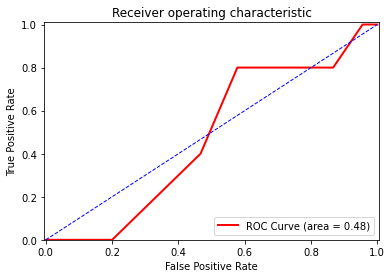

In [32]:
plt.plot(fprX, tprX, color='red', lw=2, 
         label='ROC Curve (area = %0.2f)' % AUCX)

# Random Guess line:
plt.plot([0, 1], [0, 1], color='blue', lw=1, linestyle='--')

# Defining The Range of X-Axis and Y-Axis:
plt.xlim([-0.005, 1.005])
plt.ylim([0.0, 1.01])

# Labels, Title, Legend:
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")


